# 08. PyTorch Paper Replicating

Author: Ross Hunter

Date: 2025-10-11

Goal: Turn an ML research paper into usable code.
This notebook will focus on replicating the ViT (Vision Transformer) paper in PyTorch.


Source paper: *An Image is Worth 16x16 Words* -  https://arxiv.org/abs/2010.11929

Reference:
* Docs:
  * International mathematical notation symbols reference - https://www.cambridgeinternational.org/Images/420009-mathematics-notation-list-.pdf
* Tools:
  * For turning equations into Latex format - https://snip.mathpix.com/

## Setup
Import helper functions and required libraries.



In [77]:
try:
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")
except:
  print(f"[INFO] torch/torchvision versions don't meet the min requirements, installing...")
  !pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")

torch version: 2.8.0+cu126
torchvision version: 0.23.0+cu126


In [78]:
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

try:
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them.")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

In [79]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Get Data

In [80]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [81]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Prepare transforms for the images

In [82]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224 # From table 3 of the ViT paper.

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


## Create `DataLoader` objects from the images.

In [83]:
BATCH_SIZE = 32 # The paper uses a bigger batch size, but we are going to use a smaller number to start out with.

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

## Visualize a single image

In [84]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


(torch.Size([3, 224, 224]), tensor(0))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

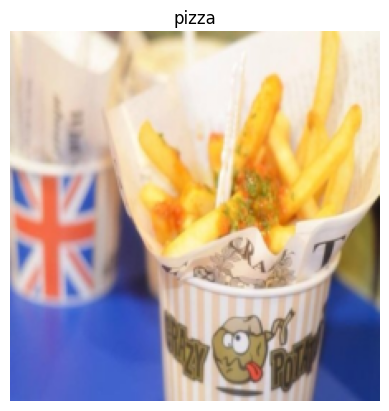

In [85]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

## Replicating ViT: Overview

Let's break the project down into smaller steps.

1. Inputs - what goes into the model. In this case, image tensors.
2. Outputs - In this case, image classification labels.
3. Layers - Takes an input, manipulates it with a function, (for example, self attention function)
4. Blocks - Collection of layers
5. Model - Collection of blocks


### ViT Overview: pieces of the puzzle

Figure 1: Visual overview of the architecture
For equations: math equations which define the functions of each layer/block
Table 1/3: different hyperparameters for the architecture / training
Text

### Figure 1

![figure_01](https://drive.google.com/uc?export=view&id=19ZAD9KvkH4jSz0g6UYhHpWPZSc6w5slW)

* Embedding - learnable representation start with random numbers and improve them over time.

### Four equations

![four_equations](https://drive.google.com/uc?export=view&id=1VSlzS1eB5LSCHIKjKzT01V5Nc8Rs9t9k)


An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where ( $H, W$ ) is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

### Table 1

![table_01](https://drive.google.com/uc?export=view&id=1taAg1wXNe0o-tjIn5-v0N75_OMyNRstN)



* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time

Equation 1 (Embedded Patches) Pseudocode:
```python
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] +
[class_token_pos,image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```

Equation 2 (MSA: Multi-Head Attention):
```python
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```

Equation 3 (MLP: MLP Blocks):
MLP - Multi Layer Perceptron
```python
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

Equation 4:
```python
y_output = linear_layer(LN_layer(x_output_MLP_block))

* ViT-Base, ViT-Large, and ViT-Huge are all different sizes of the same model architecture.
* Layers - the number of transformer encoder layers
* Hidden size $D$ - the embedding size throughout the architecture.
* MLP size - the number of hidden units / neurons in the MLP
* Head - the number of multi-head self-attention

## Split data into patches and create the class, position and patch embedding.

Layers = input -> function -> output

Input shape:
(224, 224, 3)

$H\times{W}\times{C}$
(height x width x color channels)

Output shape: $\mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$

* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / p^2
* D = constant latent vector size = embedding dimension (see Table 1)



In [86]:
# Create example
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / (patch_size ** 2)) # double multiply symbol means exponenet
constan_latent_vector_size = 768 # from Table 1

number_of_patches, constan_latent_vector_size

(196, 768)

In [87]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape N x (P^2 * C)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)
# Embedding layer input and output shapes
print(f"Input shape (single 2D color image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}") # (num patches, size of flattened patch (embedding_dimension))

Input shape (single 2D color image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

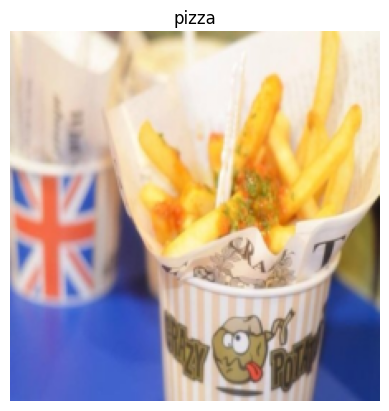

In [88]:
# View a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [89]:
image.shape

torch.Size([3, 224, 224])

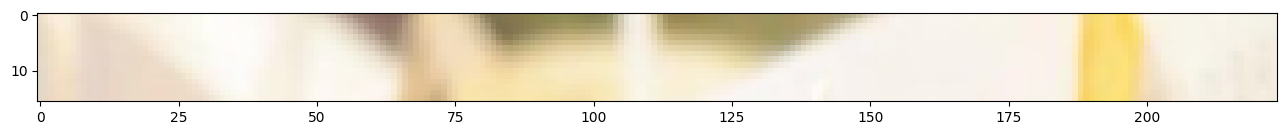

In [90]:
image_permuted = image.permute(1,2,0)

patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels
patch: 0, patch_size: 16
patch: 16, patch_size: 16
patch: 32, patch_size: 16
patch: 48, patch_size: 16
patch: 64, patch_size: 16
patch: 80, patch_size: 16
patch: 96, patch_size: 16
patch: 112, patch_size: 16
patch: 128, patch_size: 16
patch: 144, patch_size: 16
patch: 160, patch_size: 16
patch: 176, patch_size: 16
patch: 192, patch_size: 16
patch: 208, patch_size: 16


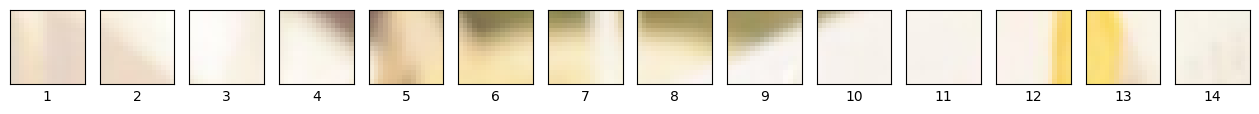

In [91]:
# "it's all about the embedding" - if you can make a
# good embedding, your ML architecture is probably going to work pretty well.
# Task: split up the row in the above cell to patches.
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axes = plt.subplots(nrows=1,
                         ncols=img_size // patch_size,
                         sharex=True,
                         sharey=True,
                         figsize=(patch_size, patch_size))

# Iterate through the number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  # Step through the permuted image (the one with the colors as the last part of the tensor array)
  # and display the current row, iterating through it one patch at a time.
  print(f"patch: {patch}, patch_size: {patch_size}")
  axes[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axes[i].set_xlabel(i+1)
  axes[i].set_xticks([])
  axes[i].set_yticks([])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


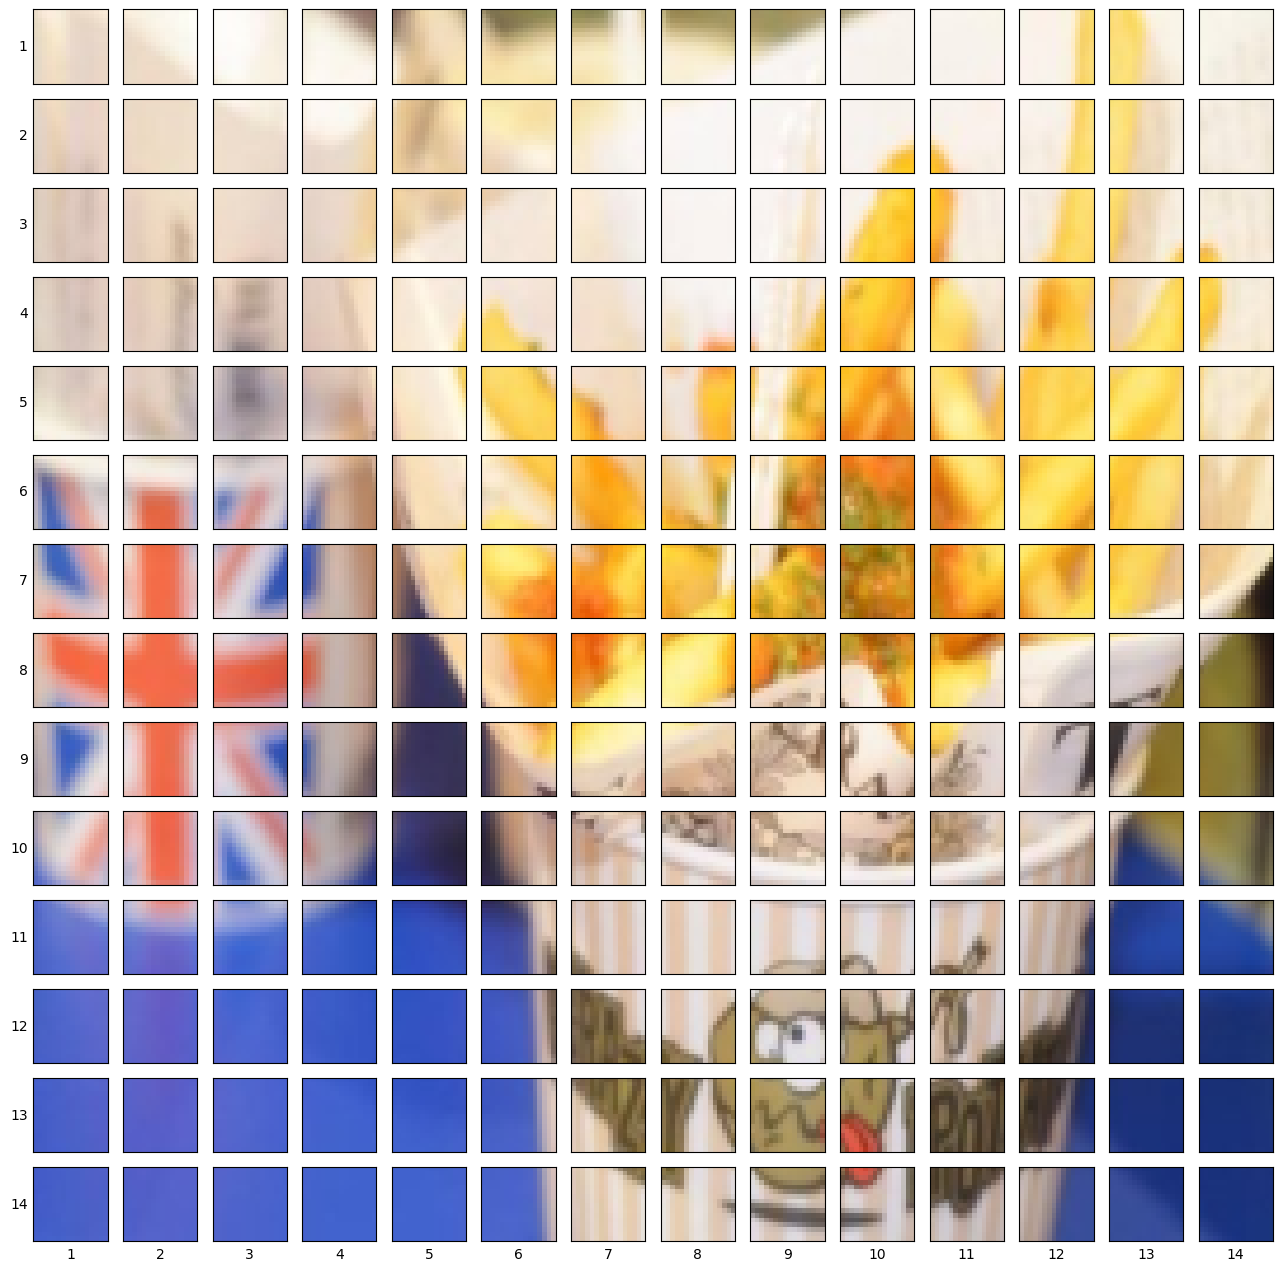

In [92]:
# Loop through both dimensions
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axes = plt.subplots(nrows=img_size // patch_size,
                         ncols=img_size // patch_size,
                         sharex=True,
                         sharey=True,
                         figsize=(patch_size, patch_size))

# Iterate through the rows
for count, row in enumerate(range(0, img_size, patch_size)):
  #print(f"Current row: {row}")
  # Iterate through the number of patches in the top row
  for i, patch in enumerate(range(0, img_size, patch_size)):
    #print(f"Current col: {i}")
    # Step through the permuted image (the one with the colors as the last part of the tensor array)
    # and display the current row, iterating through it one patch at a time.
    axes[count][i].imshow(image_permuted[row:row+patch_size, patch:patch+patch_size, :]);
    axes[count][i].set_ylabel(count+1, rotation="horizontal",
                              horizontalalignment="right",
                              verticalalignment="center")
    axes[count][i].set_xlabel(i+1)
    axes[count][i].set_xticks([])
    axes[count][i].set_yticks([])
    axes[count][i].label_outer()



In [93]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # For color images
                   out_channels=768, # D size from Table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [94]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels, height, width)
# The number of pixels in the image: 768 = patch_size**2 * color_channels = image patches * color channels
# pixels of each image patch: 14 * 14 = 196
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [95]:
flatten = nn.Flatten(start_dim=2, end_dim=3)
flatten

Flatten(start_dim=2, end_dim=3)

In [96]:
### Feature Map - the input sequence for the ViT transformer architecture.
# 768 feature maps (patch embeddings) of 196 pixels each
# 196 pixels per patch (14,14) from conv output
# 768 pixels in the original unprocessed image (16 x 16 x 3)
# ( 768 different convolution steps with a 196 embedding representing each convolution)
flattened_image = flatten(image_out_of_conv)
flattened_image.squeeze(0).shape

torch.Size([768, 196])

In [97]:
### Rearranged Feature Map
# The tensor from the above output wasn't arranged in the correct order
# Use permute() to fix the tensor shape so it matches our
# desired output.
flattened_image_reshaped = flattened_image.permute(0, 2, 1)
print(f"The new tensor shape: {flattened_image_reshaped.shape}")

The new tensor shape: torch.Size([1, 196, 768])


Flattened feature map shape: torch.Size([1, 196])


(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

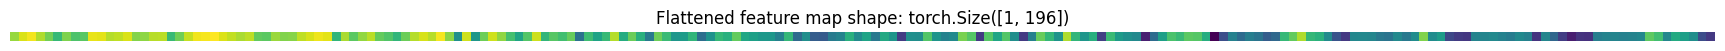

In [98]:
# Single embedding : creates a shallow copy of the entire list
# The embeddings can also be called vectors.
print(f"Flattened feature map shape: {flattened_image_reshaped[:, :, 0].shape}")
single_flattened_feature_map = flattened_image_reshaped[:, :, 0]

plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy()) # detach() removes gradient tracking. if gradient tracking is left on it could produce an error.
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)


# Now create a single PyTorch layer that:
# 1. takes the image
# 2. turns it into patches
# 3. performs the convolution step
# 4. Peforms the flatten step

In [99]:
class PatchEmbedding(nn.Module):
  """ Turns a 2D input image into a 1D sequence of learnable patch embeddings.
  Args:
    in_channels (int): Number of color channels for the input images.
    patch_size (int): Size of patches to convert the input image into.
    embedding_dim (int): Size of the embedding to turn the image into.
  """
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768):
    super().__init__()

    # Create a layer to turn an image into patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)
    # Reduce the final two matrix dimensions into one.
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  def forward(self, x):
    #print(x.shape)
    image_resolution = x.shape[-1] # get the last value in the tuple, which is the image width dimension.
    assert image_resolution % patch_size == 0, f"Image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # Make sure the output shape is correct
    # use permute to change the order of the matrix elements
    return x_flattened.permute(0, 2, 1)

In [100]:
# Layers instantiate with random weights, so lets use static seeds
# for testing purposes.
set_seeds()
patchify = PatchEmbedding()
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Output patch embedding shape: torch.Size([1, 196, 768])


Input: The image starts as 2D with size ${H \times W \times C}$.
Output: The image gets converted to a 1D sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.
Where:

$(H, W)$ is the resolution of the original image.
$C$ is the number of channels.
$(P, P)$ is the resolution of each image patch (patch size).
$N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer.

In [101]:
# Here's what a single dimension of the vector looks like.
patch_embedded_image[0][0][0]

tensor(-0.9367, grad_fn=<SelectBackward0>)

In [102]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.9367,  0.2304, -0.2421,  ...,  0.6643, -0.4334,  0.3613],
         [-1.0070,  0.2692, -0.2000,  ...,  0.7158, -0.4675,  0.3300],
         [-1.0018,  0.2214, -0.2645,  ...,  0.7654, -0.4640,  0.3747],
         ...,
         [-0.4357,  0.0886, -0.2266,  ...,  0.2279, -0.1188,  0.4053],
         [-0.2672,  0.0792, -0.1765,  ...,  0.2662, -0.0755,  0.1098],
         [-0.2222,  0.0906, -0.1315,  ...,  0.2308, -0.0616,  0.0505]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


## Create the class token

In [103]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares
# the same size as the embedding dimension. (D)
# [batch_size, number_of_tokens, embedding_dimension]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure the embedding is learnable



In [104]:
print(class_token[:, :, :10])
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [105]:
# Add the class token embedding to the front of the patch embeddings
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # Concat on dimension 1, the group of patches.

print(patch_embedded_image_with_class_embedding.shape)

torch.Size([1, 197, 768])


## Creating the position embedding

In [106]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.9367,  0.2304, -0.2421,  ...,  0.6643, -0.4334,  0.3613],
          [-1.0070,  0.2692, -0.2000,  ...,  0.7158, -0.4675,  0.3300],
          ...,
          [-0.4357,  0.0886, -0.2266,  ...,  0.2279, -0.1188,  0.4053],
          [-0.2672,  0.0792, -0.1765,  ...,  0.2662, -0.0755,  0.1098],
          [-0.2222,  0.0906, -0.1315,  ...,  0.2308, -0.0616,  0.0505]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [107]:
height, width

(224, 224)

In [108]:
# Calculate N (number_of_patches)
number_of_patches = int((height * width) / patch_size**2)
# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]
# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # Make sure it's learnable.

# Show the first 10 sequences and 10 position embedding values and check the shape
print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")


tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [109]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding

print(f"Patch+Class: {patch_embedded_image_with_class_embedding}")
print(f"Patch+Class+Positional: {patch_and_position_embedding}")

print(f"Patch embedding, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

Patch+Class: tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.9367,  0.2304, -0.2421,  ...,  0.6643, -0.4334,  0.3613],
         [-1.0070,  0.2692, -0.2000,  ...,  0.7158, -0.4675,  0.3300],
         ...,
         [-0.4357,  0.0886, -0.2266,  ...,  0.2279, -0.1188,  0.4053],
         [-0.2672,  0.0792, -0.1765,  ...,  0.2662, -0.0755,  0.1098],
         [-0.2222,  0.0906, -0.1315,  ...,  0.2308, -0.0616,  0.0505]]],
       grad_fn=<CatBackward0>)
Patch+Class+Positional: tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
         [ 0.0633,  1.2304,  0.7579,  ...,  1.6643,  0.5666,  1.3613],
         [-0.0070,  1.2692,  0.8000,  ...,  1.7158,  0.5325,  1.3300],
         ...,
         [ 0.5643,  1.0886,  0.7734,  ...,  1.2279,  0.8812,  1.4053],
         [ 0.7328,  1.0792,  0.8235,  ...,  1.2662,  0.9245,  1.1098],
         [ 0.7778,  1.0906,  0.8685,  ...,  1.2308,  0.9384,  1.0505]]],
       grad_fn=<AddBackward0>)
Patch embedding, 

## Image Patch Embeddings, Class Token, and Position Embedding together as one step

In [110]:
# Layers instantiate with random weights, so lets use static seeds
# for testing purposes.
set_seeds()

## TODO: Get image height, width, and add a batch dimension here.

# our patch embedding class
patchify = PatchEmbedding()
patch_embedded_image = patchify(image.unsqueeze(0))

# Get the batch size and embedding dimension
# This is for later when we are doing batches
# Making it dynamic so the code will work for different batch sizes.
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares
# the same size as the embedding dimension. (D)
# [batch_size, number_of_tokens, embedding_dimension]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure the embedding is learnable

# Add the class token embedding to the front of the patch embeddings
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # Concat on dimension 1, the group of patches.

### The Position Embedding ###
# Calculate N (number_of_patches)
number_of_patches = int((height * width) / patch_size**2)
# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]
# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(batch_size,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # Make sure it's learnable.

# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding

print(patch_and_position_embedding.shape)
print(patch_and_position_embedding)

torch.Size([1, 197, 768])
tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
         [ 0.0633,  1.2304,  0.7579,  ...,  1.6643,  0.5666,  1.3613],
         [-0.0070,  1.2692,  0.8000,  ...,  1.7158,  0.5325,  1.3300],
         ...,
         [ 0.5643,  1.0886,  0.7734,  ...,  1.2279,  0.8812,  1.4053],
         [ 0.7328,  1.0792,  0.8235,  ...,  1.2662,  0.9245,  1.1098],
         [ 0.7778,  1.0906,  0.8685,  ...,  1.2308,  0.9384,  1.0505]]],
       grad_fn=<AddBackward0>)


## Equation 2: Multihead Self-Attention (MSA block)

In [111]:
# Set up the LayerNorm layer by passing it the embeddings dimension
# from our patches.
layer_norm = nn.LayerNorm(patch_and_position_embedding.shape[-1])
normalized_embeddings = layer_norm(patch_and_position_embedding)
normalized_embeddings.shape

torch.Size([1, 197, 768])

Normalization - make everything have the same mean and the same standard deviation.
When we normalize alone the embedding dimension, it's like making all the stairs in a staircase the same size.

In [112]:
print(normalized_embeddings)

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-1.8476,  0.4678, -0.4697,  ...,  1.3285, -0.8490,  0.7273],
         [-1.8751,  0.5185, -0.3615,  ...,  1.3561, -0.8632,  0.6326],
         ...,
         [-1.4616,  0.2755, -0.7685,  ...,  0.7371, -0.4115,  1.3249],
         [-1.2353,  0.3604, -0.8176,  ...,  1.2214, -0.3523,  0.5015],
         [-1.2192,  0.4981, -0.7212,  ...,  1.2679, -0.3376,  0.2779]]],
       grad_fn=<NativeLayerNormBackward0>)


In [113]:
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               attn_dropout:int=0):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    self.msa_layer = nn.MultiheadAttention(embed_dim=embedding_dim,
                                           num_heads=num_heads,
                                           dropout=attn_dropout,
                                           batch_first=True)

  def forward(self, x):
    x = self.layer_norm(x) #patch_and_position_embedding
    attn_output, _ = self.msa_layer(query=x,
                                    key=x,
                                    value=x,
                                    need_weights=False)
    return attn_output

In [118]:
# Create an instance MSA block
msa_block = MultiHeadSelfAttentionBlock()

# Pass the patch and position image embedding through MSABlock
patched_image_through_msa_block = msa_block(patch_and_position_embedding)
print(f"{patch_and_position_embedding}, {patch_and_position_embedding.shape}")
print(f"{patched_image_through_msa_block}, {patched_image_through_msa_block.shape}")

tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
         [ 0.0633,  1.2304,  0.7579,  ...,  1.6643,  0.5666,  1.3613],
         [-0.0070,  1.2692,  0.8000,  ...,  1.7158,  0.5325,  1.3300],
         ...,
         [ 0.5643,  1.0886,  0.7734,  ...,  1.2279,  0.8812,  1.4053],
         [ 0.7328,  1.0792,  0.8235,  ...,  1.2662,  0.9245,  1.1098],
         [ 0.7778,  1.0906,  0.8685,  ...,  1.2308,  0.9384,  1.0505]]],
       grad_fn=<AddBackward0>), torch.Size([1, 197, 768])
tensor([[[ 0.0300, -0.2171,  0.1389,  ..., -0.2644, -0.0063, -0.6450],
         [ 0.0367, -0.2167,  0.1403,  ..., -0.2616,  0.0089, -0.6522],
         [ 0.0367, -0.2168,  0.1408,  ..., -0.2617,  0.0085, -0.6524],
         ...,
         [ 0.0401, -0.2127,  0.1419,  ..., -0.2644,  0.0091, -0.6558],
         [ 0.0401, -0.2114,  0.1412,  ..., -0.2576, -0.0024, -0.6558],
         [ 0.0399, -0.2099,  0.1430,  ..., -0.2584, -0.0044, -0.6571]]],
       grad_fn=<TransposeBackward0>), torch.Size([1, 197, 

In [132]:
# Let's set up the MLP block, which is the 3rd equation in the list
# of equations.
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               dropout:int=0.1,
               mlp_size:int=3072):
    super().__init__();

    # Create Norm Layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the Multilayer Perceptron Layer (MLP)
    self.mlp_layer = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout) # "Dropout, when used is applied after every dense layer."
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp_layer(x)
    return x

In [133]:
mlp_block = MLPBlock()
image_post_mlp_block = mlp_block(patched_image_through_msa_block)

In [134]:
image_post_mlp_block

tensor([[[-0.0407,  0.0722, -0.4571,  ..., -0.1860,  0.0987,  0.2711],
         [ 0.0250,  0.1247, -0.0000,  ..., -0.1716,  0.1327,  0.2640],
         [ 0.1665,  0.2256, -0.5019,  ..., -0.1541, -0.0495,  0.2778],
         ...,
         [-0.0035,  0.1710, -0.4185,  ..., -0.0885, -0.0168,  0.2074],
         [ 0.0866,  0.1176, -0.6658,  ..., -0.2365,  0.1119,  0.0961],
         [-0.0466,  0.2308, -0.4974,  ..., -0.2990,  0.1695,  0.1745]]],
       grad_fn=<MulBackward0>)

## Create the Transformer Encoder Class

In [135]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               dropout:int=0.1,
               mlp_size:int=3072):
    super().__init__()

    # TODO: define blocks here
    # MSA Block
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                  num_heads=num_heads,
                                                  attn_dropout=dropout)
    # MLP Block
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              num_heads=num_heads,
                              dropout=dropout,
                              mlp_size=mlp_size)
  def forward(self, x):
    # Order is:
    # Embedded Patches ->
    # Transformer Encoder[Lx](MSA -> residual -> MLP -> residual)
    # Here we deal with just the TE(MSA -> residual -> MLP -> residual)
    x = self.msa_block(x) + x # add the residual connection at the end
    x = self.mlp_block(x) + x
    return x

In [136]:
# let's test it with default params.
transformer_encoder_block = TransformerEncoderBlock()
image_post_transformer = transformer_encoder_block(patch_and_position_embedding)

In [137]:
image_post_transformer

tensor([[[ 2.1815,  1.7866,  1.2735,  ...,  2.4902,  2.2653,  1.8955],
         [ 0.5587,  1.0362,  0.0510,  ...,  2.1393,  0.5379,  1.1095],
         [ 0.4203,  1.1404, -0.1182,  ...,  2.2474,  0.4308,  1.0748],
         ...,
         [ 0.9767,  0.8131, -0.2145,  ...,  1.8432,  0.8793,  1.1424],
         [ 1.2448,  0.9675, -0.1228,  ...,  1.7430,  1.0603,  0.9098],
         [ 1.2854,  0.9054,  0.0069,  ...,  1.7328,  1.0913,  0.7809]]],
       grad_fn=<AddBackward0>)